In [9]:
%%HTML
<button onclick="$('.input, .prompt, .output_stderr, .output_error, .output_result').toggle();">Toggle Code</button>

In [3]:
import sys
sys.path.insert(0, '../valuate')

#-*- coding=utf-8 -*-
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import time
import pymysql
import numpy as np
import pandas as pd
pd.set_option('precision', 2)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set(font_scale=1.5) 

from common import common_plot

In [4]:
def describe_missing_data(df, num):
    """
    展示pandas的missing data
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(num))

def print_domain_rate(df, domain, rate):
    return len(df.loc[((df['domain'] == domain) & (df['rate'] <= rate)), :]) / len(df.loc[(df['domain'] == domain), :])

def print_domain_category_rate(df, domain, category, rate):
    return len(df.loc[((df['domain'] == domain) & (df['category'] == category) & (df['rate'] <= rate)), :]) / len(df.loc[((df['domain'] == domain) & (df['category'] == category)), :])

def print_domain_model_detail_slug(df, domain):
    model_detail_slug = len(set(df.loc[(df['domain'] == domain), :]['model_detail_slug'].values))
    all_slug = len(set(df.loc[(df['domain'] == domain), :]['model_detail_slug'].values))
    return  model_detail_slug / all_slug

def get_rate_dummies(df, rate):
    if df['rate'] <= rate:
        return 1
    else:
        return 0

In [5]:
competed_data = pd.read_csv('../tmp/report/report_compete_data.csv')
overall = competed_data.loc[:, ['car_id','domain','category','use_time','price','predict_price','model_slug','model_detail_slug']]
# overall['predict_price'] = overall['predict_price'].astype(float)
overall = overall.convert_objects(convert_numeric=True)
overall['predict_price'] = overall['predict_price'] * 100
# overall['predict_price'] = overall['predict_price'].astype(int)
overall['price'] = overall['price'] * 100
overall['rate'] = abs((overall['predict_price'] - overall['price']) / overall['price'])
overall['rate<=0.05'] = overall['rate'].apply(lambda x: 1 if x <= 0.05 else 0)
overall['rate<=0.1'] = overall['rate'].apply(lambda x: 1 if x <= 0.1 else 0)
overall['rate<=0.2'] = overall['rate'].apply(lambda x: 1 if x <= 0.2 else 0)

# 估值平台分析报告
### 时间节点:~-10.25

In [6]:
model_nums = len(set(overall.model_detail_slug.values))
car_source_nums = len(set(overall.car_id.values))
print('覆盖款型数:',len(set(overall.model_detail_slug.values)))
print('车源数:',len(set(overall.car_id.values)))

覆盖款型数: 9905
车源数: 51185


## 一.整体，分维度分析比较
### 1.全数据比较

车300全数据百分之5以内比率: 0.36
公平价全数据百分之5以内比率: 0.38
精真估全数据百分之5以内比率: 0.29
-----------------------
车300全数据百分之10以内比率: 0.66
公平价全数据百分之10以内比率: 0.65
精真估全数据百分之10以内比率: 0.56
-----------------------
车300全数据百分之20以内比率: 0.91
公平价全数据百分之20以内比率: 0.86
精真估全数据百分之20以内比率: 0.86


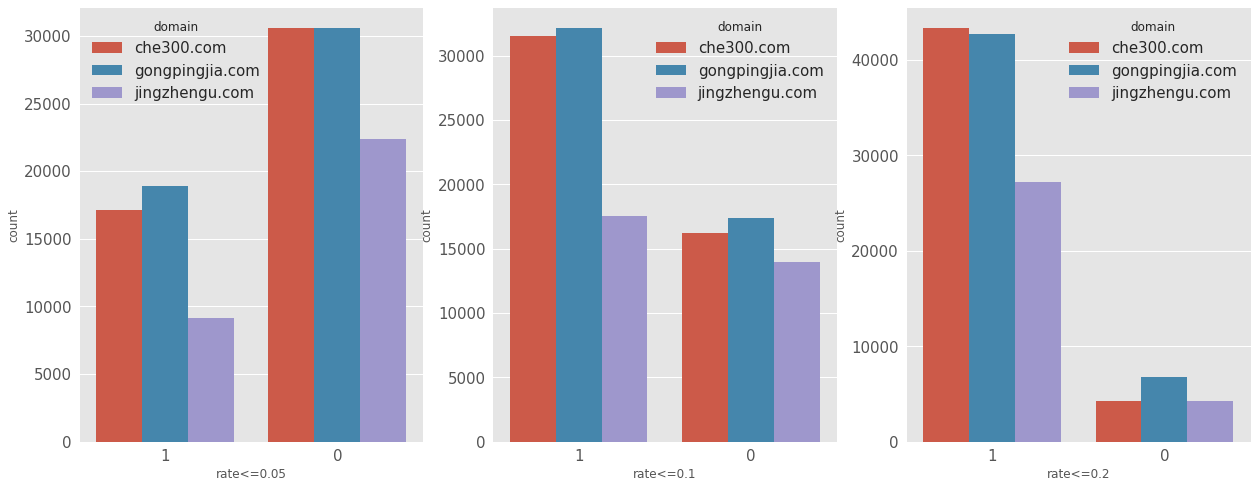

In [22]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(21,8))
sns.countplot(x='rate<=0.05', hue="domain", data=overall, order=[1,0], ax=axis1)
sns.countplot(x='rate<=0.1', hue="domain", data=overall, order=[1,0], ax=axis2)
sns.countplot(x='rate<=0.2', hue="domain", data=overall, order=[1,0], ax=axis3)

print('车300全数据百分之5以内比率: %.2f' % print_domain_rate(overall, 'che300.com', 0.05))
print('公平价全数据百分之5以内比率: %.2f' % print_domain_rate(overall, 'gongpingjia.com', 0.05))
print('精真估全数据百分之5以内比率: %.2f' % print_domain_rate(overall, 'jingzhengu.com', 0.05))
print('-----------------------')
print('车300全数据百分之10以内比率: %.2f' % print_domain_rate(overall, 'che300.com', 0.1))
print('公平价全数据百分之10以内比率: %.2f' % print_domain_rate(overall, 'gongpingjia.com', 0.1))
print('精真估全数据百分之10以内比率: %.2f' % print_domain_rate(overall, 'jingzhengu.com', 0.1))
print('-----------------------')
print('车300全数据百分之20以内比率: %.2f' % print_domain_rate(overall, 'che300.com', 0.2))
print('公平价全数据百分之20以内比率: %.2f' % print_domain_rate(overall, 'gongpingjia.com', 0.2))
print('精真估全数据百分之20以内比率: %.2f' % print_domain_rate(overall, 'jingzhengu.com', 0.2))

### 2.车商零售价比较

车300车商零售价百分之5以内比率: 0.36
公平价车商零售价百分之5以内比率: 0.41
精真估车商零售价百分之5以内比率: 0.28
-----------------------
车300车商零售价百分之10以内比率: 0.66
公平价车商零售价百分之10以内比率: 0.67
精真估车商零售价百分之10以内比率: 0.55
-----------------------
车300车商零售价百分之20以内比率: 0.92
公平价车商零售价百分之20以内比率: 0.89
精真估车商零售价百分之20以内比率: 0.88


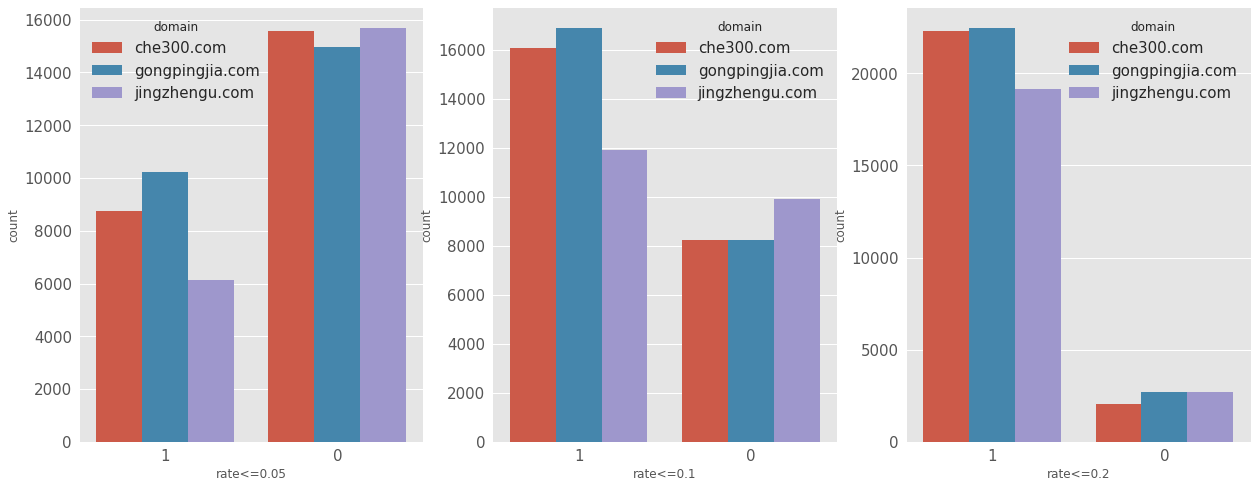

In [23]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(21,8))
rate5_perc = overall[overall['category'] == 'b_2_c']
sns.countplot(x='rate<=0.05', hue="domain", data=rate5_perc, order=[1,0], ax=axis1)
sns.countplot(x='rate<=0.1', hue="domain", data=rate5_perc, order=[1,0], ax=axis2)
sns.countplot(x='rate<=0.2', hue="domain", data=rate5_perc, order=[1,0], ax=axis3)

print('车300车商零售价百分之5以内比率: %.2f' % print_domain_category_rate(overall, 'che300.com', 'b_2_c', 0.05))
print('公平价车商零售价百分之5以内比率: %.2f' % print_domain_category_rate(overall, 'gongpingjia.com', 'b_2_c', 0.05))
print('精真估车商零售价百分之5以内比率: %.2f' % print_domain_category_rate(overall, 'jingzhengu.com', 'b_2_c', 0.05))
print('-----------------------')
print('车300车商零售价百分之10以内比率: %.2f' % print_domain_category_rate(overall, 'che300.com', 'b_2_c', 0.1))
print('公平价车商零售价百分之10以内比率: %.2f' % print_domain_category_rate(overall, 'gongpingjia.com', 'b_2_c', 0.1))
print('精真估车商零售价百分之10以内比率: %.2f' % print_domain_category_rate(overall, 'jingzhengu.com', 'b_2_c', 0.1))
print('-----------------------')
print('车300车商零售价百分之20以内比率: %.2f' % print_domain_category_rate(overall, 'che300.com', 'b_2_c', 0.2))
print('公平价车商零售价百分之20以内比率: %.2f' % print_domain_category_rate(overall, 'gongpingjia.com', 'b_2_c', 0.2))
print('精真估车商零售价百分之20以内比率: %.2f' % print_domain_category_rate(overall, 'jingzhengu.com', 'b_2_c', 0.2))

### 3.个人交易价比较

车300个人交易价百分之5以内比率: 0.39
公平价个人交易价百分之5以内比率: 0.43
-----------------------
车300个人交易价百分之10以内比率: 0.69
公平价个人交易价百分之10以内比率: 0.71
-----------------------
车300个人交易价百分之20以内比率: 0.92
公平价个人交易价百分之20以内比率: 0.92


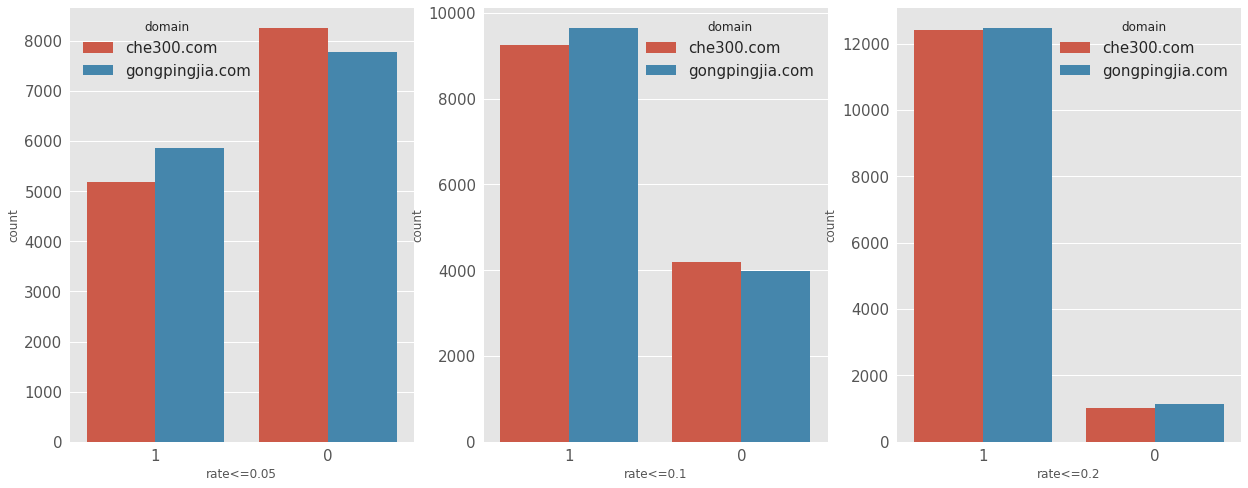

In [24]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(21,8))
rate5_perc = overall[overall['category'] == 'c_2_c']
sns.countplot(x='rate<=0.05', hue="domain", data=rate5_perc, order=[1,0], ax=axis1)
sns.countplot(x='rate<=0.1', hue="domain", data=rate5_perc, order=[1,0], ax=axis2)
sns.countplot(x='rate<=0.2', hue="domain", data=rate5_perc, order=[1,0], ax=axis3)


print('车300个人交易价百分之5以内比率: %.2f' % print_domain_category_rate(overall, 'che300.com', 'c_2_c', 0.05))
print('公平价个人交易价百分之5以内比率: %.2f' % print_domain_category_rate(overall, 'gongpingjia.com', 'c_2_c', 0.05))
print('-----------------------')
print('车300个人交易价百分之10以内比率: %.2f' % print_domain_category_rate(overall, 'che300.com', 'c_2_c', 0.1))
print('公平价个人交易价百分之10以内比率: %.2f' % print_domain_category_rate(overall, 'gongpingjia.com', 'c_2_c', 0.1))
print('-----------------------')
print('车300个人交易价百分之20以内比率: %.2f' % print_domain_category_rate(overall, 'che300.com', 'c_2_c', 0.2))
print('公平价个人交易价百分之20以内比率: %.2f' % print_domain_category_rate(overall, 'gongpingjia.com', 'c_2_c', 0.2))

### 4.车商收购价

车300车商收购价百分之5以内比率: 0.32
公平价车商收购价百分之5以内比率: 0.27
精真估车商收购价百分之5以内比率: 0.31
-----------------------
车300车商收购价百分之10以内比率: 0.62
公平价车商收购价百分之10以内比率: 0.52
精真估车商收购价百分之10以内比率: 0.58
-----------------------
车300车商收购价百分之20以内比率: 0.87
公平价车商收购价百分之20以内比率: 0.73
精真估车商收购价百分之20以内比率: 0.83


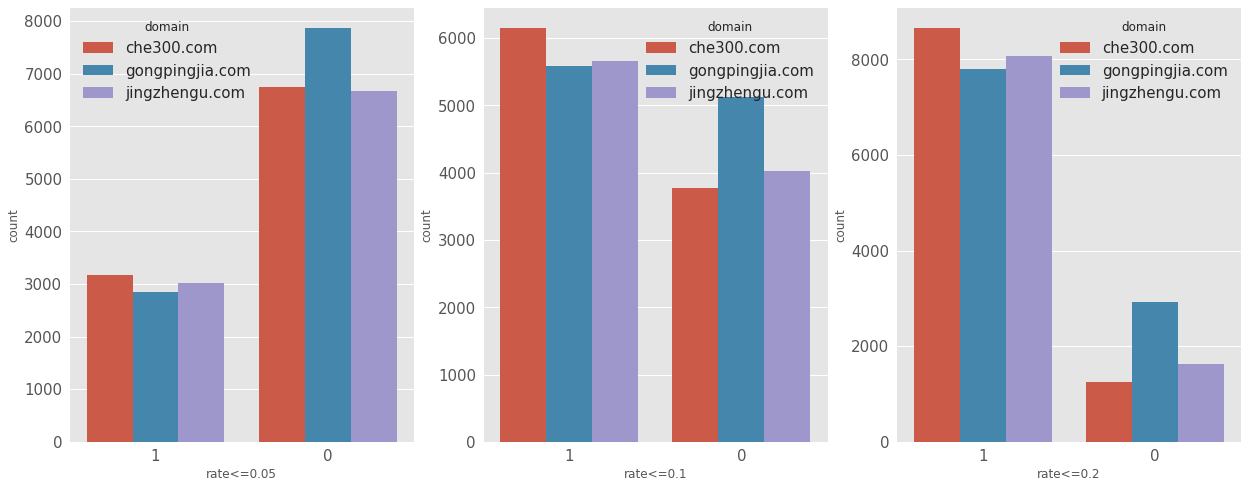

In [25]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(21,8))
rate5_perc = overall[overall['category'] == 'c_2_b']
sns.countplot(x='rate<=0.05', hue="domain", data=rate5_perc, order=[1,0], ax=axis1)
sns.countplot(x='rate<=0.1', hue="domain", data=rate5_perc, order=[1,0], ax=axis2)
sns.countplot(x='rate<=0.2', hue="domain", data=rate5_perc, order=[1,0], ax=axis3)

print('车300车商收购价百分之5以内比率: %.2f' % print_domain_category_rate(overall, 'che300.com', 'c_2_b', 0.05))
print('公平价车商收购价百分之5以内比率: %.2f' % print_domain_category_rate(overall, 'gongpingjia.com', 'c_2_b', 0.05))
print('精真估车商收购价百分之5以内比率: %.2f' % print_domain_category_rate(overall, 'jingzhengu.com', 'c_2_b', 0.05))
print('-----------------------')
print('车300车商收购价百分之10以内比率: %.2f' % print_domain_category_rate(overall, 'che300.com', 'c_2_b', 0.1))
print('公平价车商收购价百分之10以内比率: %.2f' % print_domain_category_rate(overall, 'gongpingjia.com', 'c_2_b', 0.1))
print('精真估车商收购价百分之10以内比率: %.2f' % print_domain_category_rate(overall, 'jingzhengu.com', 'c_2_b', 0.1))
print('-----------------------')
print('车300车商收购价百分之20以内比率: %.2f' % print_domain_category_rate(overall, 'che300.com', 'c_2_b', 0.2))
print('公平价车商收购价百分之20以内比率: %.2f' % print_domain_category_rate(overall, 'gongpingjia.com', 'c_2_b', 0.2))
print('精真估车商收购价百分之20以内比率: %.2f' % print_domain_category_rate(overall, 'jingzhengu.com', 'c_2_b', 0.2))

## 二.各平台价格精度分布
#### 说明:以下是密度图
#### rate<=0.05 = 0:表示>5%
#### rate<=0.05 = 1:表示<5%
### 1.车商零售价

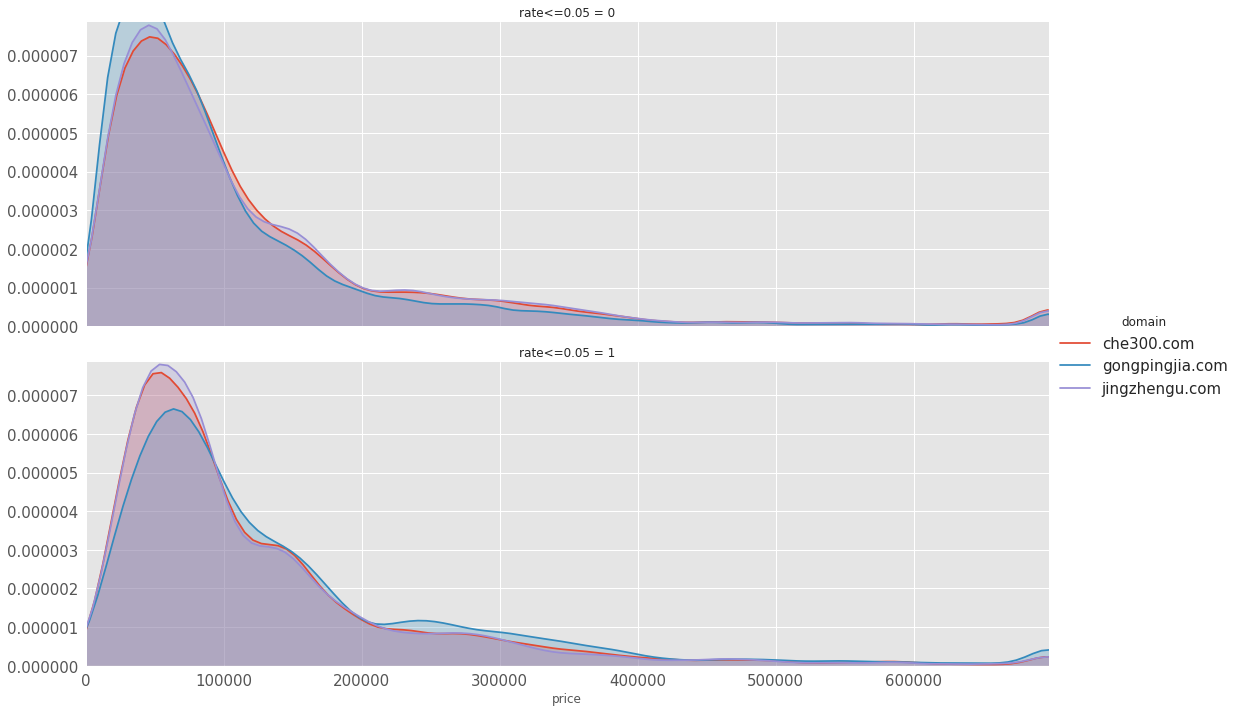

In [26]:
per_analysis = overall[overall['category'] == 'b_2_c']

def plot_distribution( df , var , target , **kwargs ):
    ulimit = np.percentile(df[var].values, 99)
    llimit = np.percentile(df[var].values, 1)
    df[var].ix[df[var]>ulimit] = ulimit
    df[var].ix[df[var]<llimit] = llimit
    
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , size=5, aspect=3 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
plot_distribution( per_analysis , var = 'price' , target = 'domain' , row = 'rate<=0.05' )

### 2.个人交易价

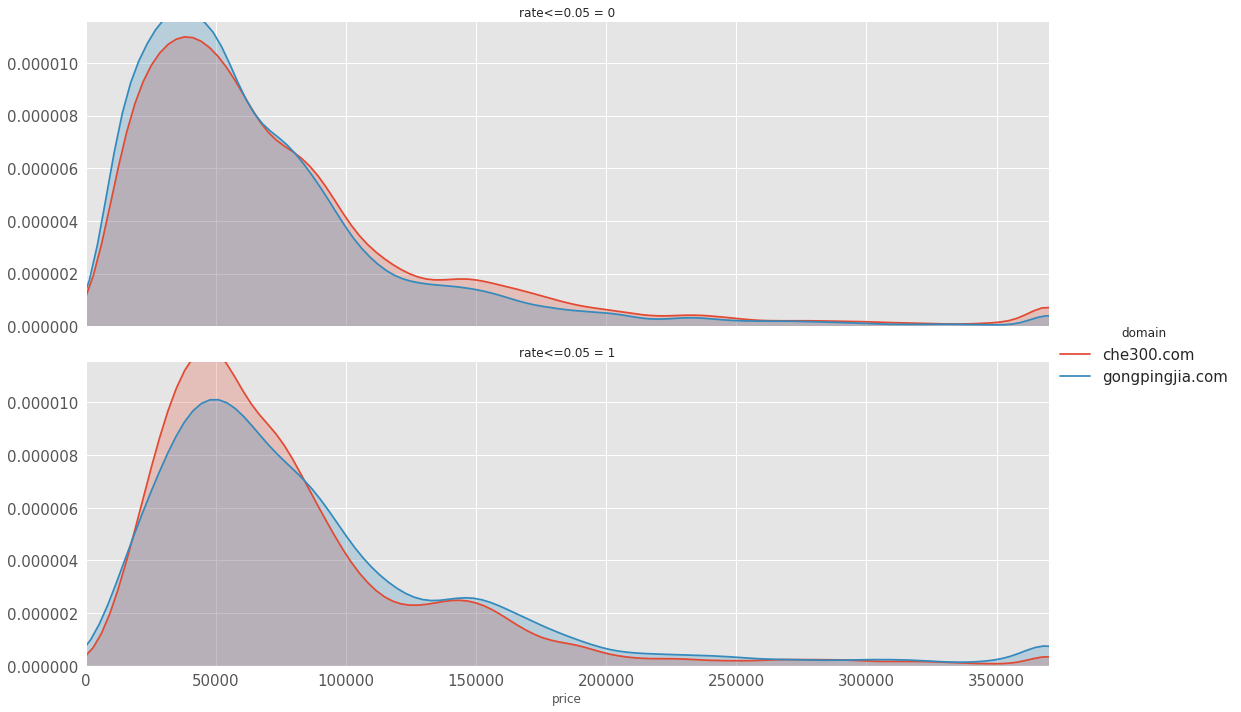

In [28]:
per_analysis = overall[overall['category'] == 'c_2_c']

def plot_distribution( df , var , target , **kwargs ):
    ulimit = np.percentile(df[var].values, 99)
    llimit = np.percentile(df[var].values, 1)
    df[var].ix[df[var]>ulimit] = ulimit
    df[var].ix[df[var]<llimit] = llimit
    
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , size=5, aspect=3 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
plot_distribution( per_analysis , var = 'price' , target = 'domain' , row = 'rate<=0.05' )

### 3.车商收购价格

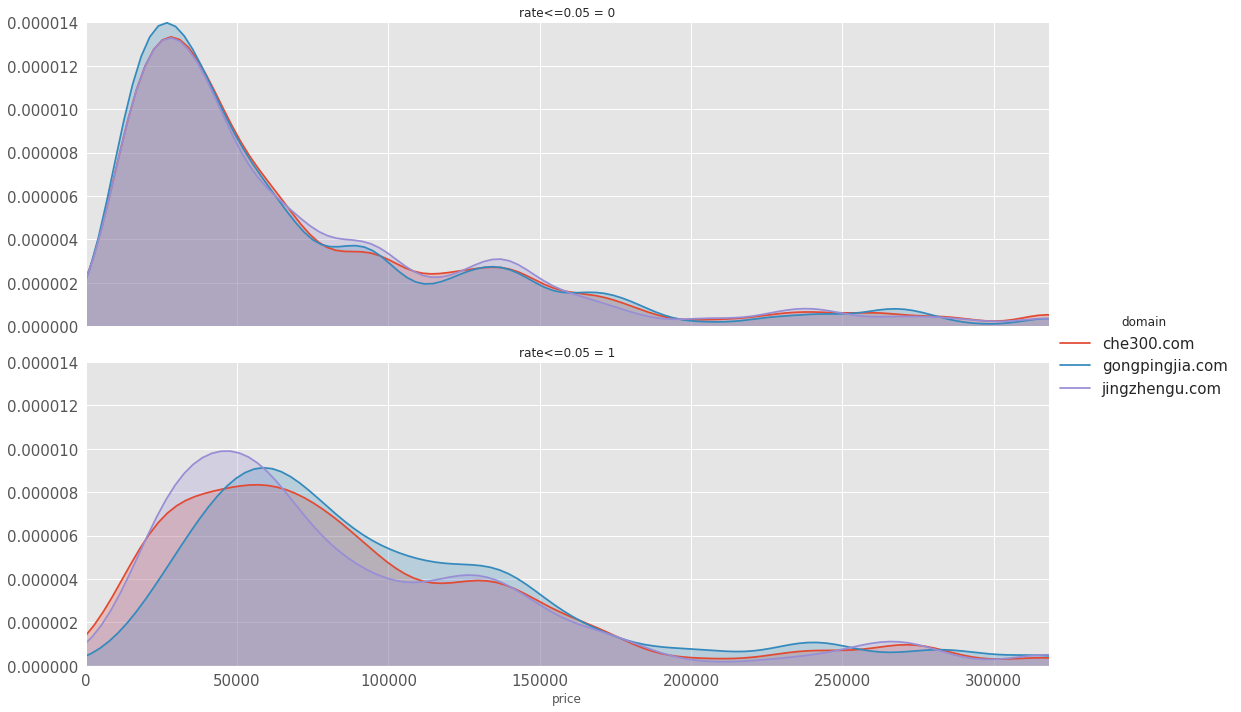

In [29]:
per_analysis = overall[overall['category'] == 'c_2_b']

def plot_distribution( df , var , target , **kwargs ):
    ulimit = np.percentile(df[var].values, 99)
    llimit = np.percentile(df[var].values, 1)
    df[var].ix[df[var]>ulimit] = ulimit
    df[var].ix[df[var]<llimit] = llimit
    
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , size=5, aspect=3 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
plot_distribution( per_analysis , var = 'price' , target = 'domain' , row = 'rate<=0.05' )

## 三.公平价预测值分布分析
### 1.交易价分布

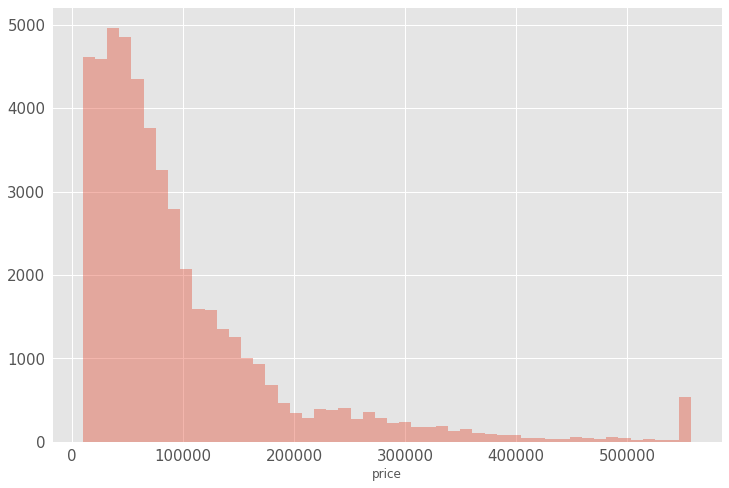

In [30]:
gongpingjia = overall[overall['domain'] == 'gongpingjia.com']
common_plot.target_values_and_nums_distributed(gongpingjia,'price')

### 2.预测值分布(0:大于5%,1:小于5%)

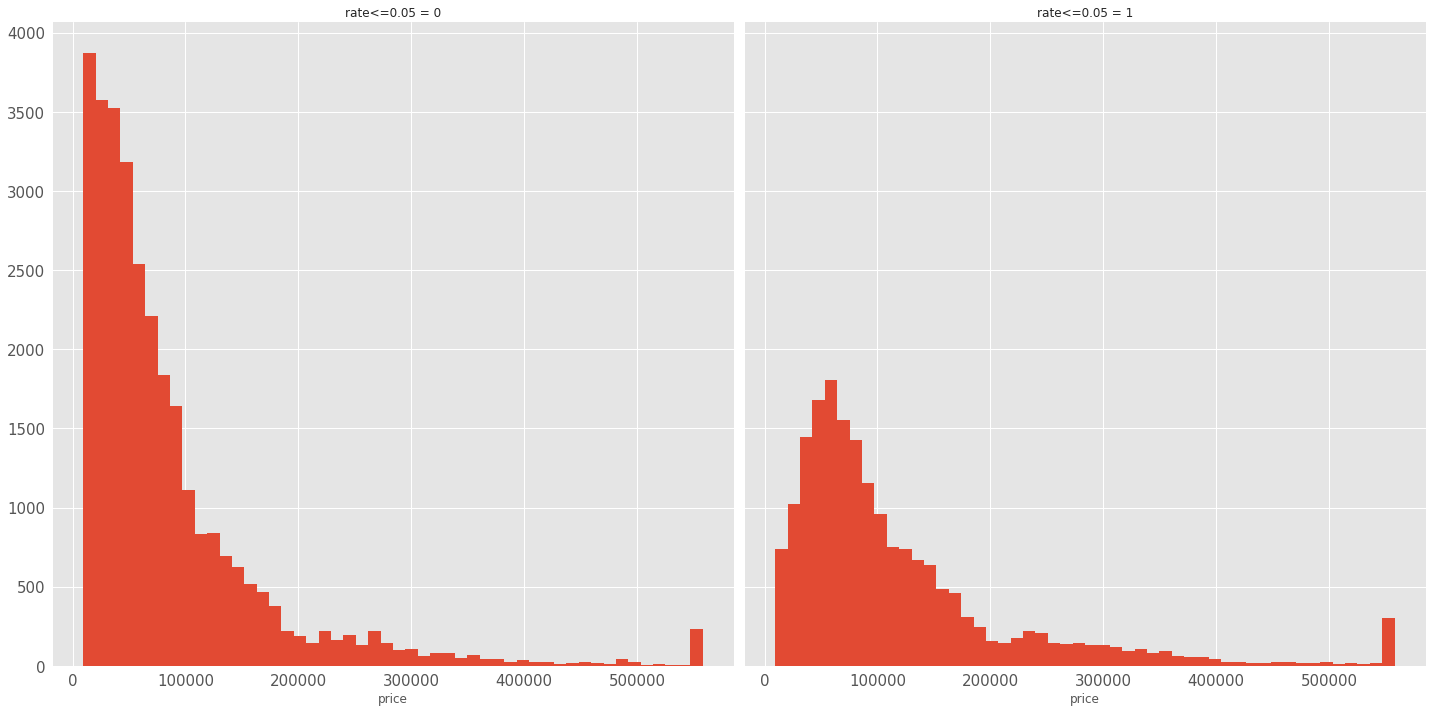

In [31]:
grid = sns.FacetGrid(gongpingjia, col="rate<=0.05", col_wrap=2, size=10,aspect=1)
bp = grid.map(plt.hist, "price", bins=50)

### 3.预测值分布(0:大于10%,1:小于10%)

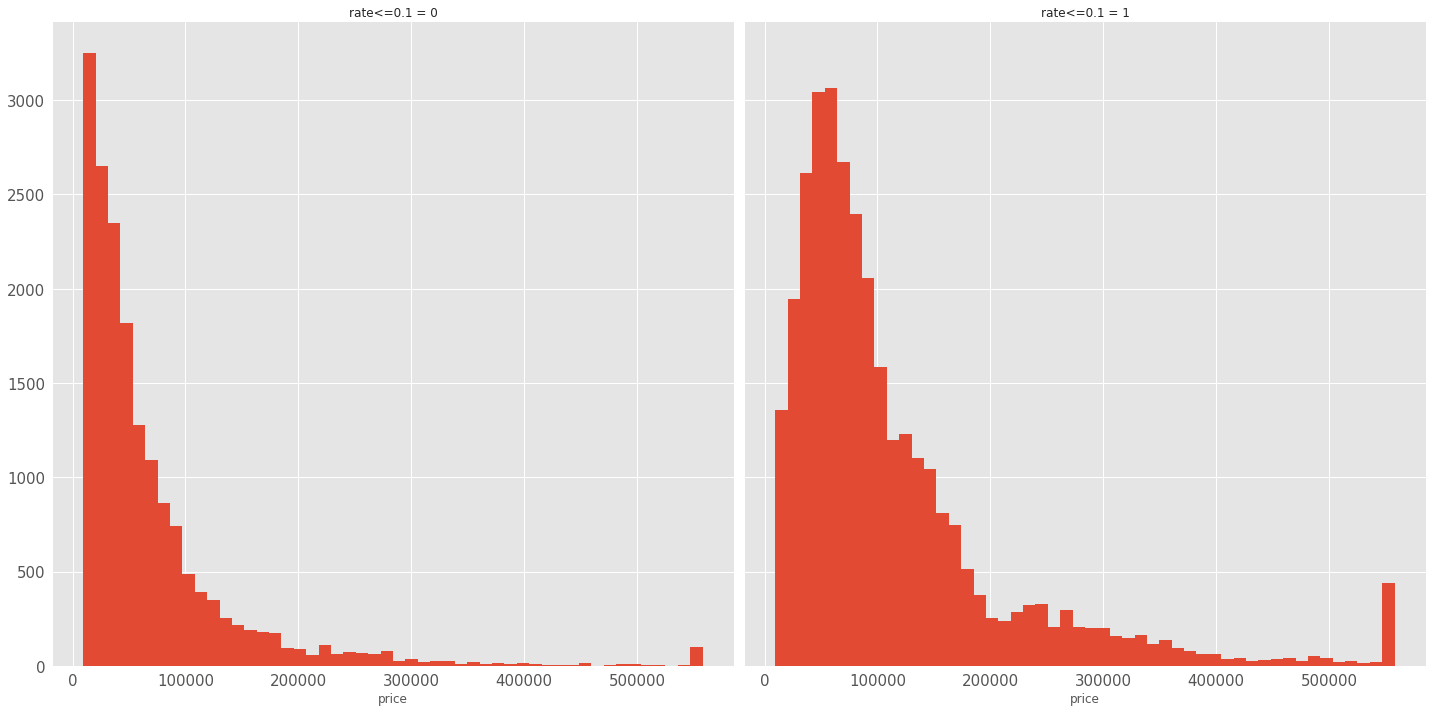

In [32]:
grid = sns.FacetGrid(gongpingjia, col="rate<=0.1", col_wrap=2, size=10,aspect=1)
bp = grid.map(plt.hist, "price", bins=50)

### 4.预测值分布(0:大于20%,1:小于20%)

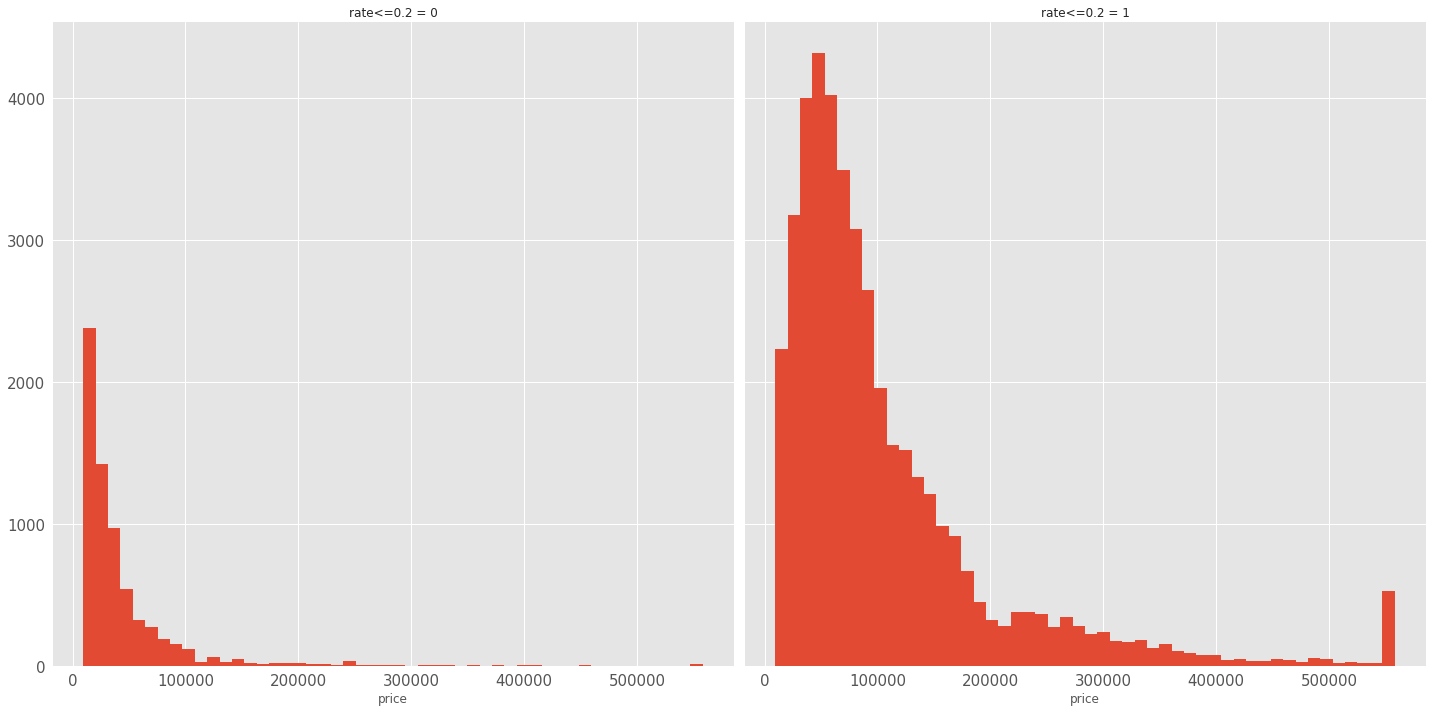

In [33]:
grid = sns.FacetGrid(gongpingjia, col="rate<=0.2", col_wrap=2, size=10,aspect=1)
bp = grid.map(plt.hist, "price", bins=50)

### 5.使用时间分布

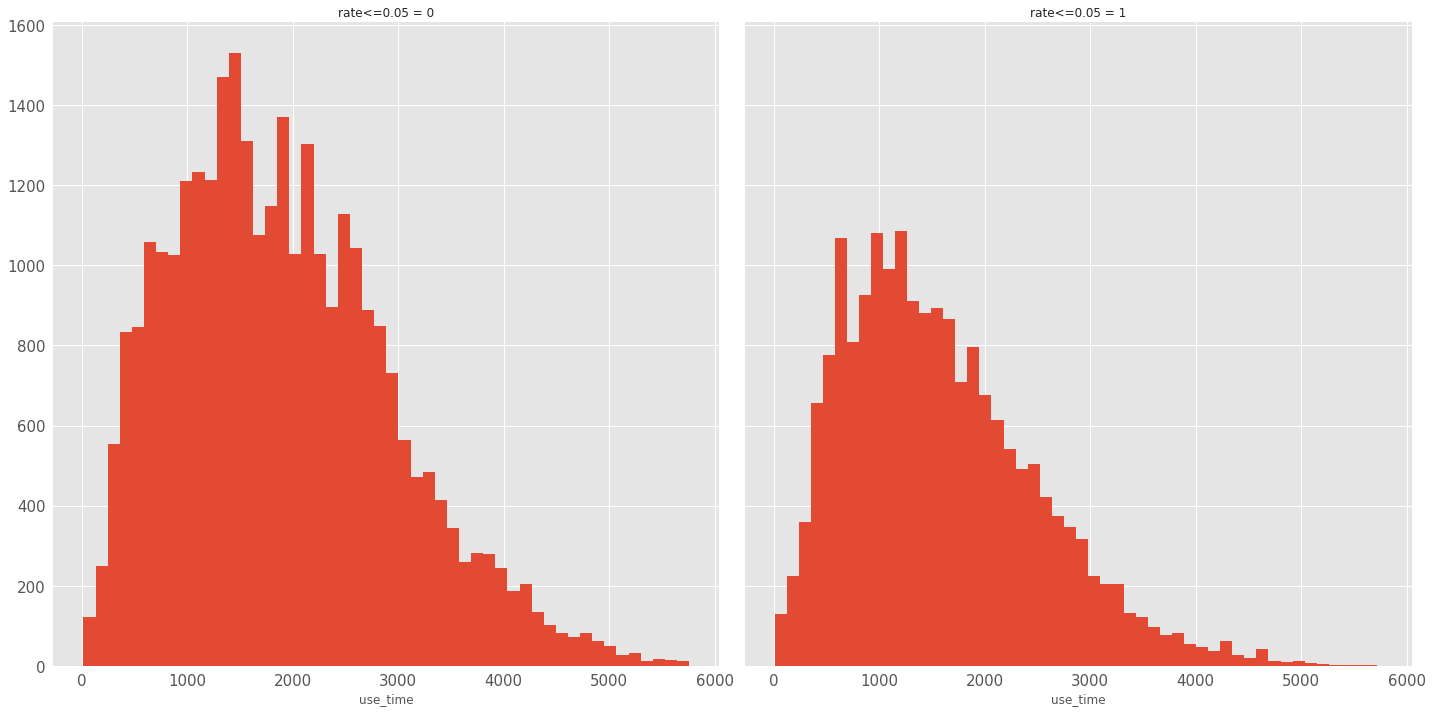

In [34]:
grid = sns.FacetGrid(gongpingjia, col="rate<=0.05", col_wrap=2, size=10,aspect=1)
bp = grid.map(plt.hist, "use_time", bins=50)